In [1]:
!pip install -q pymupdf
!pip install -q pytesseract
!pip install -q paddleocr
!pip install -q pillow
!pip install -q python-doctr
!pip install -q git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [2]:
from google.colab import drive
import sys
import os
import json
import re
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2
import fitz
import pytesseract
import paddleocr
from paddleocr import PaddleOCR
import doctr
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

print('Python version:         ' + sys.version)
print('MatPlotLib version:     ' + mpl.__version__)
print('NumPy version:          ' + np.__version__)
print('OpenCV version:         ' + cv2.__version__)
print('PyMuPDF (fitz):         ' + fitz.__version__)
print('PyTesseract version:    ' + pytesseract.__version__)
print('PaddleOCR version:      ' + paddleocr.__version__)
print('DocTR version:          ' + doctr.__version__)
print('PyTorch version:        ' + torch.__version__)
print('Transformers version:   ' + transformers.__version__)

Python version:         3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
MatPlotLib version:     3.10.0
NumPy version:          2.0.2
OpenCV version:         4.10.0
PyMuPDF (fitz):         1.26.3
PyTesseract version:    0.3.13
PaddleOCR version:      3.1.1
DocTR version:          v1.0.0
PyTorch version:        2.6.0+cu124
Transformers version:   4.56.0.dev0


In [3]:
drive.mount('/content/google-drive', force_remount=True)
directory_files_with_tables = "/content/google-drive/MyDrive/Technical task (COXIT)/Files with tables/"

Mounted at /content/google-drive


In [4]:
# =====================================
# Обробка зображення сторінки файлу PDF
# =====================================

# Рендерінг зображення з визначеним DPI, перетворення в NumPy масив, отримання геометричної інформації про зображення
def render_PDF_file_page(PDF_file_path, dpi=600):
    document = fitz.open(PDF_file_path)
    page = document[0]
    zoom = dpi / 72.0
    zoom_matrix = fitz.Matrix(zoom, zoom)
    pixmap = page.get_pixmap(matrix=zoom_matrix, alpha=False)
    image = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.height, pixmap.width, pixmap.n).copy()
    width_pt, height_pt = float(page.rect.width), float(page.rect.height)
    document.close()
    return image, width_pt, height_pt, zoom

# Кольорове зображення -> бінаризоване зображення (білий - тексти, таблиці, картинки; чорні - фон)
def binarize_image(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel_size = max(25, (min(grayscale.shape) // 80) // 2 * 2 + 1)
    top_hat = cv2.morphologyEx(grayscale, cv2.MORPH_TOPHAT, cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size)))
    binarized_image = cv2.adaptiveThreshold(top_hat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, blockSize=41, C=12)
    return binarized_image

In [5]:
# ============================================================
# Геометричний та проекційний аналіз бінаризованого зображення
# ============================================================

# Ділить обмежувальну рамку на частини за проміжками проекційного профілю
def split_bounding_box_by_patches(binarized_image, box, axis="vertical", min_patch_fraction=0.03, min_segment_fraction=0.16, smooth_k_fraction=0.01):
    x0, y0, x1, y1 = box
    cropped_image = binarized_image[y0 : y1, x0 : x1]
    if cropped_image.size == 0:
        return None
    projection = cropped_image.sum(axis=0 if axis=="vertical" else 1).astype(np.float32)
    projection_length = projection.shape[0]

    # Згладжування профілю гаусовим фільтром
    def smooth_Gaussian_filter(v, k):
        kernel_size = max(5, int(k) | 1)
        return cv2.GaussianBlur(v.astype(np.float32), (kernel_size, 1), 0).ravel()

    projection = smooth_Gaussian_filter(projection, max(5, int(smooth_k_fraction * projection_length)))
    threshold = 0.22 * (projection.max() if projection.max() > 0 else 1.0)
    mask = (projection < threshold).astype(np.uint8)
    runs = []
    s = None
    min_run = max(10, int(min_patch_fraction * projection_length))
    for i, v in enumerate(mask):
        if v == 1 and s is None:
            s = i
        if (v == 0 or i == projection_length - 1) and s is not None:
            e = i if v == 0 else i + 1
            if (e - s) >= min_run:
                runs.append((s, e))
            s = None
    if not runs:
        return None
    splits = [int((a + b) // 2) for (a, b) in runs]
    segments = []
    previous = 0
    for split in splits:
        segments.append((previous, split))
        previous = split
    segments.append((previous, projection_length))
    min_width = int(min_segment_fraction * projection_length)
    segments = [ab for ab in segments if (ab[1] - ab[0]) >= min_width]
    if len(segments) <= 1:
        return None
    coordinates = []
    for a, b in segments:
        if axis=="vertical":
            coordinates.append((x0 + a, y0, x0 + b, y1))
        else:
            coordinates.append((x0, y0 + a, x1, y0 + b))
    return coordinates

# Зменшує обмежувальну рамку так, щоб вона щільно охоплювала таблиці у бінаризованому зображенні
def tighten_bounding_box_to_table(binarized_image, box, padding=8, min_row_fraction=0.01, min_column_fraction=0.01):
    x0, y0, x1, y1 = box
    cropped_image = binarized_image[y0 : y1, x0 : x1]
    if cropped_image.size == 0:
        return box
    height, width = cropped_image.shape
    row_sum = cropped_image.sum(axis=1)
    column_sum = cropped_image.sum(axis=0)
    row_threshold = max(1, int(min_row_fraction * 255 * width))
    column_threshold = max(1, int(min_column_fraction * 255 * height))
    rows = np.where(row_sum > row_threshold)[0]
    columns = np.where(column_sum > column_threshold)[0]
    if len(rows) == 0 or len(columns) == 0:
        return box
    y0n, y1n = y0 + rows[0] - padding, y0 + rows[-1] + padding
    x0n, x1n = x0 + columns[0] - padding, x0 + columns[-1] + padding
    return (max(0, x0n), max(0, y0n), x1n, y1n)

# Оцінює наявність таблиць в області бінаризованого зображення
def estimate_tables_on_image(binarized_image, box):
    x0, y0, x1, y1 = box
    cropped_image = binarized_image[y0 : y1, x0 : x1]
    if cropped_image.size == 0:
        return 0.0, (0, 0)
    ys, xs = np.nonzero(cropped_image)
    if len(xs) < 30:
        return 0.0, (0, 0)

    # Рахує кількість піків у розподілі точок (приблизна кількість рядків/колонок)
    def count_peaks(array, bin_width):
        if array.size < 3:
            return 0
        min_elemnt, max_element = float(array.min()), float(array.max())
        number_bins = max(3, int((max_element - min_elemnt) / bin_width))
        histogram, _ = np.histogram(array, bins=number_bins)
        if histogram.max() == 0:
            return 0
        return int((histogram >= max(2, int(0.3 * histogram.max()))).sum())

    number_columns = count_peaks(xs, max(10, (x1 - x0) // 40))
    number_rows = count_peaks(ys, max(10, (y1 - y0) // 50))
    score = (min(number_columns, 6) / 6.0 + min(number_rows , 10) / 10.0) / 2.0
    return score, (number_columns, number_rows)

# Визначає, чи є обмежувальна рамка зовнішньою рамкою усієї сторінки файлу PDF
def bounding_box_is_page_edge(x, y, w, h, page_width, page_height, page_edge_fraction=0.02, area_ratio_threshold=0.60):
    page_edge = int(page_edge_fraction * min(page_width, page_height))
    hits = int(x <= page_edge) + int(y <= page_edge) + int(page_width - (x + w) <= page_edge) + int(page_height - (y + h) <= page_edge)
    if hits >= 2 and (w * h) / (page_width * page_height) >= area_ratio_threshold:
        return True
    if w / page_width > 0.92 and h / page_height > 0.92:
        return True
    return False

In [6]:
# ================================================================================
# Виявлення та локалізація таблиць за допомогою горизонтальних обмежувальних рамок
# ================================================================================

# Детектування таблиць на зображенні з використанням вище визначених функцій та алгоритму Non-Maximum Suppression
def detect_tables_on_image(PDF_file_path, dpi=600):
    img, Wpt, Hpt, zoom = render_PDF_file_page(PDF_file_path, dpi=dpi)
    bin_img = binarize_image(img)
    H, W = bin_img.shape

    v_k1 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, max(12, H // 90)))
    h_k1 = cv2.getStructuringElement(cv2.MORPH_RECT, (max(18, W // 60), 1))
    vmap = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, v_k1, iterations=1)
    hmap = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, h_k1, iterations=1)
    grid_like = cv2.bitwise_and(vmap, hmap)

    v_k2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, max(8, H // 110)))
    h_k2 = cv2.getStructuringElement(cv2.MORPH_RECT, (max(12, W // 80), 1))
    dense_cols = cv2.dilate(bin_img, v_k2, iterations=1)
    dense_rows = cv2.dilate(bin_img, h_k2, iterations=1)
    pseudo_grid = cv2.bitwise_and(dense_cols, dense_rows)

    cand = cv2.bitwise_or(grid_like, pseudo_grid)
    contours, _ = cv2.findContours(cand, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    raw = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w * h < 0.003 * W * H:
            continue
        if bounding_box_is_page_edge(x, y, w, h, W, H):
            continue
        raw.append((x, y, x + w, y + h))

    split = []
    for (x0, y0, x1, y1) in raw:
        w = x1 - x0
        h = y1 - y0
        did_split = False
        if w / W > 0.55:
            s = split_bounding_box_by_patches(bin_img, (x0, y0, x1, y1), axis="vertical", min_patch_fraction=0.03, min_segment_fraction=0.16, smooth_k_fraction=0.01)
            if s:
                split.extend(s)
                did_split = True
        if not did_split and h / H > 0.35:
            s = split_bounding_box_by_patches(bin_img, (x0,y0,x1,y1), axis="horizontal", min_patch_fraction=0.03, min_segment_fraction=0.18, smooth_k_fraction=0.01)
            if s:
                split.extend(s)
                did_split = True
        if not did_split:
            split.append((x0, y0, x1, y1))
    refined = [tighten_bounding_box_to_table(bin_img, b, padding=8) for b in split]
    boxes = []
    scores = []
    for b in refined:
        sc, (nc, nr) = estimate_tables_on_image(bin_img, b)
        x0, y0, x1, y1 = b
        if sc >= 0.22 and nc >= 3 and nr >= 6 and (x1 - x0) > 0.08 * W and (y1 - y0) > 0.08 * H:
            boxes.append(b)
            scores.append(sc)
    if not boxes:
        return {"file": os.path.basename(pdf_path), "tables_count": 0, "boxes_pt": []}

    idx = np.argsort(scores)[ : :-1]
    keep = []
    used = np.zeros(len(boxes), bool)

    # Intersection over Union (IoU)
    def iou(a, b):
        ax0, ay0, ax1, ay1 = a
        bx0, by0, bx1, by1 = b
        x0 = max(ax0, bx0)
        y0 = max(ay0, by0)
        x1 = min(ax1, bx1)
        y1 = min(ay1, by1)
        iw = max(0, x1 - x0)
        ih = max(0, y1 - y0)
        inter = iw * ih
        ua = (ax1 - ax0) * (ay1 - ay0) + (bx1 - bx0) * (by1 - by0) - inter
        return inter / ua

    for i in idx:
        if used[i]:
            continue
        keep.append(i)
        for j in idx:
            if used[j] or j==i:
                continue
            if iou(boxes[i], boxes[j]) >= 0.35:
                used[j]=True
    boxes = [boxes[i] for i in keep]
    boxes_pt = [(b[0] / zoom, b[1] / zoom, b[2] / zoom, b[3] / zoom) for b in boxes]
    return {"file": os.path.basename(PDF_file_path), "tables_count": len(boxes_pt), "boxes_pt": boxes_pt}

In [7]:
# =================================================
# Витягування текстових spans зі сторінки файлу PDF
# =================================================

# Вирізає шматок сторінки файлу PDF у вигляді растрового зображення (масив NumPy)
def crop_from_pdf(pdf_path, bbox_pt, dpi=800):
    doc = fitz.open(pdf_path)
    page = doc[0]
    zoom = dpi / 72.0
    rect = fitz.Rect(*bbox_pt)
    pix = page.get_pixmap(matrix=fitz.Matrix(zoom, zoom), clip=rect, alpha=False)
    img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n).copy()
    doc.close()
    return img

# Слова-підказки, які часто зустрічаються в назвах таблиць
HINTS_TEXTS = {
    "panel", "location", "fed", "fed from", "enclosure", "volts", "bus", "bus rating", "a.i.c.", "a.i.c. rating",
    "mounting", "phases", "wires", "main", "main device type", "main device size", "fault", "current", "type", "size"
}

# Стоп-слова, які не треба інтерпретувати як корисний текст
STOP_TEXTS = {
    "REVISEDENTIRESHEET", "REVISED", "ENTIRE", "SHEET", "PANELBOARDSCHEDULES", "SCHEDULES",
    "ENCLOSURE", "VOLTS", "BUS", "RATING", "BUSRATING", "A.I.C.", "A.I.C.RATING", "AIC", "AICRATING",
    "LOCATION", "MOUNTING", "PHASES", "WIRES", "MAIN", "DEVICE", "TYPE", "SIZE", "FAULT", "CURRENT"
}

# Детектор жирності шрифту по назві таблиці
def is_bold_font(font_name) -> bool:
    if not font_name:
        return False
    f = font_name.lower()
    return any(tag in f for tag in ["bold", "black", "heavy", "demi", "semibold"])

# Робить текст без зайвих пробілів/табуляцій/переносів рядків
def norm_space(s):
    return re.sub(r"\s+", " ", s).strip()

# Дістає всі текстові spans із усієї обмежувальної рамки
def spans_in_full_box(pdf_path, bbox_pt):
    doc = fitz.open(pdf_path)
    page = doc[0]
    x0, y0, x1, y1 = map(float, bbox_pt)
    rect = fitz.Rect(x0, y0, x1, y1)
    td = page.get_text("dict", clip=rect)
    doc.close()
    lines = []
    for b in td.get("blocks", []):
        for l in b.get("lines", []):
            spans = []
            for s in l.get("spans", []):
                text = norm_space(s.get("text", ""))
                if not text:
                    continue
                x0s, y0s, x1s, y1s = s.get("bbox", [0, 0, 0, 0])
                size = float(s.get("size", 0.0))
                font = s.get("font", "")
                spans.append({
                    "text": text, "size": size, "font": font, "bold": is_bold_font(font),
                    "x0": x0s, "x1": x1s, "y0": y0s, "y1": y1s
                })
            if spans:
                y_line = min(sp["y0"] for sp in spans)
                spans = sorted(spans, key=lambda sp: sp["x0"])
                lines.append({"y": y_line, "spans": spans})
    return sorted(lines, key=lambda ln: ln["y"])

# Дістає всі текстові spans із верхньої частини обмежувальної рамки
def spans_in_top_band(pdf_path, bbox_pt, band_ratio=0.30):
    doc = fitz.open(pdf_path)
    page = doc[0]
    x0, y0, x1, y1 = map(float, bbox_pt)
    h = y1 - y0
    band_rect = fitz.Rect(x0, y0, x1, y0 + max(5.0, band_ratio * h))
    td = page.get_text("dict", clip=band_rect)
    doc.close()
    lines = []
    for b in td.get("blocks", []):
        for l in b.get("lines", []):
            spans = []
            for s in l.get("spans", []):
                text = norm_space(s.get("text", ""))
                if not text:
                    continue
                x0s, y0s, x1s, y1s = s.get("bbox", [0, 0, 0, 0])
                font = s.get("font", "")
                size = float(s.get("size", 0.0))
                spans.append({
                    "text": text, "size": size, "font": font, "bold": is_bold_font(font),
                    "x0": x0s, "x1": x1s, "y0": y0s, "y1": y1s
                })
            if spans:
                y_line = min(sp["y0"] for sp in spans)
                spans = sorted(spans, key=lambda sp: sp["x0"])
                lines.append({"y": y_line, "spans": spans})
    return sorted(lines, key=lambda ln: ln["y"])

In [8]:
# ============================================
# Евристики для витягування заголовків таблиць
# ============================================

# Перевірка, що текстовий рядок містить осмислений текст (не шум)
def not_gibberish(s):
    if not s:
        return False
    t = norm_space(s)
    if len(t) < 3:
        return False
    if re.fullmatch(r"[\d/.\-]+", t):
        return False
    if not re.search(r"[A-Za-z]{3,}", t):
        return False
    return True

# Шукає заголовок таблиці у текстових spans враховуючи верхній регістр, жирність, розмір літер
def strategy_big_allcaps_code(lines):
    cand = []
    for ln in lines:
        for sp in ln["spans"]:
            t = sp["text"].strip()
            t_up = t.upper()
            t_clean = re.sub(r"[^A-Z0-9/\-]+", "", t_up)
            if len(t_clean) >= 2 and not re.search(r"PANEL|SCHEDULE", t_up, flags=re.I):
                if t_clean in STOP_TEXTS:
                    continue
                only_num = bool(re.fullmatch(r"[0-9/\-]+", t_clean))
                score = sp["size"] + (6.0 if sp["bold"] else 0.0) + (0.0 if only_num else 3.0)
                cand.append((score, t_clean))
    if not cand:
        return None
    cand.sort(key=lambda x: x[0], reverse=True)
    return cand[0][1]

# Витягує заголовок таблиці після ключових слів ("Panel"/"Location"/"Fed (From)"/...) у межах кількох рядків
def strategy_values_after_labels(lines):

    # Визначає, чи є токен шуканим ярликом і якого типу
    def _which_label(tok):
        t = tok.lower().rstrip(":")
        if t == "panel":
            return "panel"
        if t == "location":
            return "location"
        if t in ("fed from", "fed", "fedfrom"):
            return "fed"
        return None

    # Визначає межу, де закінчується поточний ярлик
    def _is_boundary(tok):
        t = tok.lower().rstrip(":")
        return (t in HINTS_TEXTS) or (tok.endswith(":"))

    found = {"panel" : None, "location" : None, "fed" : None}
    for ln in lines:
        spans = ln["spans"]
        i = 0
        while i < len(spans):
            label = _which_label(spans[i]["text"])
            if label:
                j = i + 1
                parts = []
                while j < len(spans) and not _is_boundary(spans[j]["text"]):
                    parts.append(spans[j]["text"])
                    j += 1
                value = norm_space(" ".join(parts))
                if value:
                    found[label] = value
                i = j
            else:
                i += 1
    vals = [v for k,v in (("panel", found["panel"]), ("location", found["location"]), ("fed", found["fed"])) if v]
    if vals:
        return " | ".join(vals)
    return None

# Витягує заголовок таблиці перед ключовими словами ("Panel Schedule"/...) у межах одного рядка
def _strategy_panel_schedule_line(lines):
    BAD = re.compile(r"^(REVISED|ENTIRE|SHEET|REVISEDENTIRESHEET)$", re.I)
    for ln in lines:
        line_text = norm_space(" ".join(sp["text"] for sp in ln["spans"]))
        m = re.search(r"([A-Z0-9][A-Z0-9/\-]{1,30})\s+PANEL\s+SCHEDULE", line_text, flags=re.I)
        if m:
            code = m.group(1)
            if not BAD.match(code):
                return f"{code} Panel Schedule"
        texts = [sp["text"] for sp in ln["spans"]]
        for i, t in enumerate(texts):
            if re.fullmatch(r"PANEL", t, flags=re.I) and i + 1 < len(texts) and re.fullmatch(r"SCHEDULE", texts[i + 1], flags=re.I):
                left = " ".join(texts[: i]).strip()
                m2 = re.search(r"([A-Z0-9][A-Z0-9/\-]{1,30})\s*$", left)
                if m2:
                    code = m2.group(1)
                    if not BAD.match(code):
                        return f"{code} Panel Schedule"
    return None

# Витягує заголовок таблиці перед ключовими словами ("Panel Schedule"/...) у межах кількох рядків
def strategy_panel_schedule_two_lines(lines, max_y_gap=90.0):
    rows = []
    for ln in lines:
        txt = norm_space(" ".join(sp["text"] for sp in ln["spans"]))
        size_max = max((sp["size"] for sp in ln["spans"]), default=0.0)
        bold_any = any(sp["bold"] for sp in ln["spans"])
        rows.append({"y": ln["y"], "text": txt, "spans": ln["spans"], "size": size_max, "bold": bold_any})
    ps_idx = [i for i, r in enumerate(rows)
              if re.search(r"\bPANEL\b", r["text"], flags=re.I) and re.search(r"\bSCHEDULE\b", r["text"],
              flags=re.I)]
    if not ps_idx:
        return None

    # Знаходження у текстовому рядку кращого кандидата на заголовок таблиці
    def best_code_from_row(row):
        cand = []
        for sp in row["spans"]:
            t_up = sp["text"].upper().strip()
            code = re.sub(r"[^A-Z0-9/\-]+", "", t_up)
            if len(code) < 2:
                continue
            if re.search(r"PANEL|SCHEDULE", t_up):
                continue
            if code in STOP_TEXTS:
                continue
            only_num = bool(re.fullmatch(r"[0-9/\-]+", code))
            score = sp["size"] + (6.0 if sp["bold"] else 0.0) + (0.0 if only_num else 3.0)
            cand.append((score, code))
        if not cand:
            return None
        cand.sort(key=lambda x: x[0], reverse=True)
        return cand[0][1]

    for i_ps in ps_idx:
        y_ps = rows[i_ps]["y"]
        up_rows = [r for r in rows if (r["y"] < y_ps) and ((y_ps - r["y"]) <= max_y_gap)]
        cand = []
        for r in up_rows:
            code = best_code_from_row(r)
            if code:
                score = r["size"] + (6.0 if r["bold"] else 0.0) + min(len(code), 8) * 0.2
                cand.append((score, code))
        if cand:
            cand.sort(key=lambda x: x[0], reverse=True)
            return f"{cand[0][1]} Panel Schedule"
    return "Panel Schedule"

In [9]:
# =========================================================================================
# Optical Character Recognition (OCR) та генерація заголовку таблиці на основі тексту з неї
# =========================================================================================

# Витягує нормалізований текст з растрового зображення використовуючи 3 каскади OCR-рушіїв: PaddleOCR, docTR, Tesseract
def extract_table_text_robust(img):
    text_blocks = []
    try:
        ocr = PaddleOCR(use_textline_orientation=True, lang='en')
        res = ocr.ocr(img, cls=True)
        for page in res:
            for line in page:
                txt = line[1][0]
                if txt:
                    text_blocks.append(txt)
    except Exception:
        pass

    if not text_blocks:
        try:
            model = ocr_predictor(pretrained=True)
            doc = DocumentFile.from_images([img])
            result = model(doc)
            for page in result.pages:
                for block in page.blocks:
                    for line in block.lines:
                        line_txt = " ".join([w.value for w in line.words])
                        if line_txt:
                            text_blocks.append(line_txt)
        except Exception:
            pass

    if not text_blocks:
        try:
            txt = pytesseract.image_to_string(img)
            if txt:
                text_blocks.append(txt)
        except Exception:
            pass

    txt = norm_space(" ".join(text_blocks))
    txt = re.sub(r"\s{2,}", " ", txt).strip()
    return txt

# OCR заголовку таблиці використвуючи PaddleOCR
def extract_header_text_ocr(img_crop):
    if PaddleOCR is None:
        return ""
    ocr = PaddleOCR(use_textline_orientation=True, lang='en', det=True, rec=True)
    res = ocr.ocr(img_crop, cls=True)
    if not res:
        return ""
    lines = []
    for line in res:
        for box, (txt, conf) in line:
            if txt and (conf is None or conf >= 0.2):
                lines.append((box, txt))
    if not lines:
        return ""
    lines = sorted(lines, key=lambda it: (min(p[1] for p in it[0]), min(p[0] for p in it[0])))
    text = " ".join([t for _, t in lines]).strip()
    return re.sub(r"\s+", " ", text)

# Евристичний генератор заголовку таблиці з її тексту
def heuristic_title_from_text(table_text):
    if not table_text:
        return None
    txt = table_text[:2000]
    keys = [
        "panel schedule", "circuit", "load", "location", "fed from", "breaker",
        "phase", "amps", "voltage", "distribution", "feeder", "equipment", "rating", "schedule"
    ]
    found = [k for k in keys if re.search(r"\b" + re.escape(k) + r"\b", txt, flags=re.I)]
    if found:
        uniq = []
        for k in found:
            t = k.title()
            if t not in uniq:
                uniq.append(t)
        cand = " / ".join(uniq[:3])
        if cand:
            return cand[:80]

    lines = [l.strip() for l in re.split(r"[\r\n]+", txt) if l.strip()]
    for l in lines:
        l = norm_space(l)
        if 3 <= len(l) <= 80 and re.search(r"[A-Za-zА-Яа-я0-9]", l) and not re.match(r"^\W+$", l):
            return l
    return None

# Генерація моделлю типу Sequence-to-Sequence (Flan-T5) заголовку таблиці на основі OCR інформації
def generate_table_title_model(table_text):
    if not table_text or len(table_text) < 10:
        return None

    # Чистка тексту таблиці отриманого OCR (прибирає повтори символів, службові заголовки таблиць)
    def clean_table_text_for_model(s):
        bad_patterns = [r"^\s*Location\s*/\s*Fed.*$", r"^\s*Phase.*$", r"^\s*Amps.*$"]
        lines = []
        for l in re.split(r"[\r\n]+", s):
            if any(re.match(bp, l, flags=re.I) for bp in bad_patterns):
                continue
            if re.fullmatch(r"(.)\1{2,}", l.strip(), flags=re.I):
                continue
            lines.append(l)
        return "\n".join(lines)

    # Залишає максимум `max_lines` унікальних і змістовних рядків тексту
    def precondense_table_text(s, max_lines=40):
        lines = [l.strip() for l in re.split(r"[\r\n]+", s) if l.strip()]
        uniq, seen = [], set()
        for l in lines:
            key = l.lower()
            if key in seen:
                continue
            if len(l) < 3:
                continue
            if re.fullmatch(r"[\W_]+", l):
                continue
            uniq.append(l)
            seen.add(key)
            if len(uniq) >= max_lines:
                break
        return "\n".join(uniq)

    # Обробка згенерованого моделлю заголовку таблиці (прибирає розділові знаки, обмежує довжину)
    def postprocess_generated_title(s):
        s = s.strip().strip('"“”').strip()
        s = re.sub(r"^\s*Table\s*:?\s*", "", s, flags=re.I)
        s = re.sub(r"[.;:,\-\s]+$", "", s)
        return s[:80]

    condensed_text = precondense_table_text(clean_table_text_for_model(table_text))
    prompt = (
        "You are given text extracted from a table. "
        "Generate a concise, 3–6 word title that best describes this table. "
        "Avoid generic words like 'Table' or 'Data'.\n\n"
        "Text:\n" + condensed_text
    )
    try:
        model_name = "google/flan-t5-small"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        max_src = min(512, getattr(tokenizer, "model_max_length", 512))
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_src)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=16, num_beams=4, do_sample=False, early_stopping=True)
        title = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        title = postprocess_generated_title(title)
        return title or None
    except Exception:
        return None

# Перевіряє осмисленість заголовку таблиці (довжина 3 - 80 символів, немає повторів, немає службових слів)
def is_meaningful_title(s):
    if not s:
        return False
    t = norm_space(s)
    if len(t) < 3 or len(t) > 80:
        return False
    if re.fullmatch(r"(.)\1{2,}", t, flags=re.I):
        return False
    bad = {"location", "fed", "phase", "amps"}
    if all(w.lower() in bad for w in t.split()):
        return False
    return True

In [10]:
# =========================================
# Формування чи генерація заголовку таблиці
# =========================================

# Пайплайн спроб дістати текст з таблиці, сформувати заголовок таблиці та згенерувати його
def infer_table_name(pdf_path, bbox_pt):
    try:
        top_lines = spans_in_top_band(pdf_path, bbox_pt, band_ratio=0.30)
    except Exception:
        top_lines = []

    t = _strategy_panel_schedule_line(top_lines)
    if t:
        return t[:80]

    t = strategy_panel_schedule_two_lines(top_lines, max_y_gap=90.0)
    if t:
        return t[:80]

    try:
        full_lines = spans_in_full_box(pdf_path, bbox_pt)
    except Exception:
        full_lines = []

    t = _strategy_panel_schedule_line(full_lines)
    if t:
        return t[:80]

    t = strategy_panel_schedule_two_lines(full_lines, max_y_gap=90.0)
    if t:
        return t[:80]

    t = strategy_values_after_labels(top_lines if top_lines else full_lines)
    if t:
        return t[:80]

    t = strategy_big_allcaps_code(top_lines if top_lines else full_lines)
    if t:
        return t[:80]

    try:
        crop_img = crop_from_pdf(pdf_path, bbox_pt, dpi=800)
        h = crop_img.shape[0]
        header_crop = crop_img[: max(1, int(0.18 * h)), :, :]
        ocr_text = extract_header_text_ocr(header_crop)
        if ocr_text:
            txt = norm_space(ocr_text)
            m = re.search(r"([A-Z0-9][A-Z0-9/\-]{1,30})\s+PANEL\s+SCHEDULE", txt, flags=re.I)
            if m:
                ok_code = True
                try:
                    ok_code = _looks_like_code(m.group(1))
                except Exception:
                    pass
                ok_bad = True
                try:
                    ok_bad = not _is_bad_title(m.group(1))
                except Exception:
                    pass
                if ok_code and ok_bad:
                    return f"{m.group(1).upper()} Panel Schedule"
            if re.search(r"\bPANEL\b\s+\bSCHEDULE\b", txt, flags=re.I):
                return "Panel Schedule"
    except Exception:
        pass

    try:
        if "crop_img" not in locals():
            crop_img = crop_from_pdf(pdf_path, bbox_pt, dpi=600)
        table_text = extract_table_text_robust(crop_img)
        title = generate_table_title_model(table_text)
        ok_bad = True
        try:
            ok_bad = not _is_bad_title(title)
        except Exception:
            pass
        if title and not_gibberish(title) and ok_bad:
            return title[:80]
        title = heuristic_title_from_text(table_text)
        ok_bad = True
        try:
            ok_bad = not _is_bad_title(title)
        except Exception:
            pass
        if title and not_gibberish(title) and ok_bad:
            return title[:80]
    except Exception:
        pass

    try:
        x0, y0, x1, y1 = map(float, bbox_pt)
        header_text = ""
        try:
            doc = fitz.open(pdf_path)
            page = doc[0]
            rect = fitz.Rect(x0, y0, x1, y0 + max(5.0, 0.35 * (y1 - y0)))
            td = page.get_text("dict", clip=rect) or {}
            doc.close()
            lines = []
            for b in td.get("blocks", []):
                for l in b.get("lines", []):
                    seg = " ".join(norm_space(sp.get("text", "")) for sp in l.get("spans", []) if sp.get("text"))
                    seg = norm_space(seg)
                    if seg:
                        lines.append(seg)
            header_text = norm_space(" ".join(lines[:4]))
        except Exception:
            pass
        if len(header_text) < 12:
            try:
                crop = crop_from_pdf(pdf_path, bbox_pt, dpi=650)
                H = crop.shape[0]
                header_img = crop[:max(1, int(0.35 * H)), :, :]
                header_text = extract_header_text_ocr(header_img) or ""
                header_text = norm_space(header_text)
            except Exception:
                header_text = header_text or ""
        corpus = header_text
        if len(corpus) < 30:
            try:
                if "crop" not in locals():
                    crop = crop_from_pdf(pdf_path, bbox_pt, dpi=550)
                full_txt = extract_table_text_robust(crop) or ""
                corpus = (corpus + " " + full_txt[:800]).strip()
            except Exception:
                pass

        # Вибір найкращого рядка із корпусу тексту
        def _best_header_line(text):
            lines_local = [ln.strip() for ln in re.split(r"[\r\n]+", text) if ln.strip()]
            best, best_sc = "", -1e9
            for ln in lines_local[:12] + ([" ".join(lines_local[:4])] if lines_local else []):
                alpha = sum(ch.isalpha() for ch in ln)
                digits = sum(ch.isdigit() for ch in ln)
                seps = ln.count("|") + ln.count(",") + ln.count(";")
                sc = alpha - 0.5 * digits + 2.0 * seps
                if sc > best_sc:
                    best_sc, best = sc, ln
            return best

        header_line = _best_header_line(corpus)
        raw_tokens = re.findall(r"[A-Za-z][A-Za-z0-9_\-]*", header_line)[:8]
        alias = {
            "id": "ID", "idx": "ID",
            "image": "Image", "img": "Image", "imageid": "Image ID", "image_id": "Image ID",
            "filename": "Filename", "name": "Name",
            "geometry": "Geometry", "bbox": "BBox", "box": "BBox",
            "class": "Class", "label": "Label", "category": "Category",
            "score": "Score", "prob": "Score",
            "x": "X", "y": "Y", "w": "W", "h": "H", "width": "Width", "height": "Height",
        }
        pretty, seen = [], set()
        for tkn in raw_tokens:
            k = tkn.lower().strip("_-")
            p = alias.get(k, tkn.title())
            if re.fullmatch(r"\d{1,2}[/\-]\d{1,2}", p):
                continue
            if p.lower() in seen:
                continue
            if not is_meaningful_title(p):
                continue
            seen.add(p.lower())
            pretty.append(p)
        if len(pretty) >= 2:
            return " • ".join(pretty[:6])[:80]
        kw = [w.lower() for w in re.findall(r"[A-Za-z]{3,}", corpus)]
        stop = {"the", "and", "with", "for", "from", "type", "size", "main", "amps", "phase", "phases", "table"}
        common = [w for w, _ in Counter(kw).most_common(6) if w not in stop]
        if common:
            return " ".join(w.title() for w in common[:4])[:80]
    except Exception:
        pass
    return "Table"

In [11]:
# ==========================================================================================================
# Візуалізація результатів роботи детектування таблиць на сторінці файлу PDF та генерації заголовків таблиць
# ==========================================================================================================

# Обчислення координат центрів обмежувальних рамок таблиць
def centers_from_boxes_pt(boxes_pt):
    return [((b[0] + b[2]) / 2.0, (b[1] + b[3]) / 2.0) for b in boxes_pt]

# Відображення маркеру центру та індекс усередині
def draw_center_marker(img_bgr, x_px, y_px, idx_text=None, scale=1.0):
    base_radius = 32
    base_font_scale = 2
    base_thickness = 8
    radius = int(base_radius * scale)
    font_scale = base_font_scale * scale
    thickness = max(2, int(base_thickness * scale))
    cv2.circle(img_bgr, (x_px, y_px), radius, (255, 255, 255), -1)
    cv2.circle(img_bgr, (x_px, y_px), radius, (0, 0, 0), max(3, thickness-1))
    if idx_text is not None:
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = str(idx_text)
        (tw, th), _ = cv2.getTextSize(text, font, font_scale, thickness)
        tx = int(x_px - tw / 2)
        ty = int(y_px + th / 2)
        cv2.putText(img_bgr, text, (tx, ty), font, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)

# Відображення обмежувальних рамок таблиць, маркери центрів, список кількості, назв та положень таблиць (текстом та JSON об'єктом)
def show_information_about_tables_in_file(pdf_path, dpi_show=170, round_pt=1, marker_scale=2.0):
    base = os.path.basename(pdf_path)

    if not pdf_path.lower().endswith(".pdf"):
            print(f"[File '{base}' is of a type other than PDF]")
            return

    doc = fitz.open(pdf_path)

    if len(doc) != 1:
        print(f"[PDF file '{base}' contains {len(doc)} pages (only 1-page PDF files can be used)]")
        return

    doc.close()
    res = detect_tables_on_image(pdf_path)
    boxes_pt = res.get("boxes_pt", [])
    names = [infer_table_name(pdf_path, b) for b in boxes_pt]
    centers = centers_from_boxes_pt(boxes_pt)
    img, _, _, _ = render_PDF_file_page(pdf_path, dpi=dpi_show)

    if marker_scale is None:
        marker_scale = max(0.6, dpi_show / 170.0)

    for idx, ((x0, y0, x1, y1), (cx, cy)) in enumerate(zip(boxes_pt, centers), start=1):
        X0 = int(x0 * dpi_show / 72.0)
        Y0 = int(y0 * dpi_show / 72.0)
        X1 = int(x1 * dpi_show / 72.0)
        Y1 = int(y1 * dpi_show / 72.0)
        Cx = int(cx * dpi_show / 72.0)
        Cy = int(cy * dpi_show / 72.0)
        cv2.rectangle(img, (X0, Y0), (X1, Y1), (0, 0, 255), 18)
        draw_center_marker(img, Cx, Cy, idx_text=idx, scale=marker_scale)

    plt.figure(figsize=(16, 12))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(base, fontsize=18, fontweight='bold')
    plt.show()

    print(f"Amount of tables in PDF file: {len(boxes_pt)}")
    print("Table title and position:")
    clean_names = [(n if n else "table")[:80] for n in names]
    width = min(max(max((len(n) for n in clean_names), default=24), 24), 80)
    for i, (nm, (cx, cy)) in enumerate(zip(clean_names, centers), start=1):
        left = f"{i}. {nm}".ljust(width + 3)
        print(f"{left} ({round(cx, round_pt)}, {round(cy, round_pt)})")

    table_title_position = [
        {
            "title": (nm if nm else "table"),
            "x": float(round(cx, round_pt)),
            "y": float(round(cy, round_pt))
        }
        for nm, (cx, cy) in zip(names, centers)
    ]

    result = {
        "pdf_file": base,
        "amount_of_tables": len(boxes_pt),
        "table_title_position": table_title_position
    }

    print("\nJSON object:")
    print(json.dumps(result, ensure_ascii=False, indent=2))

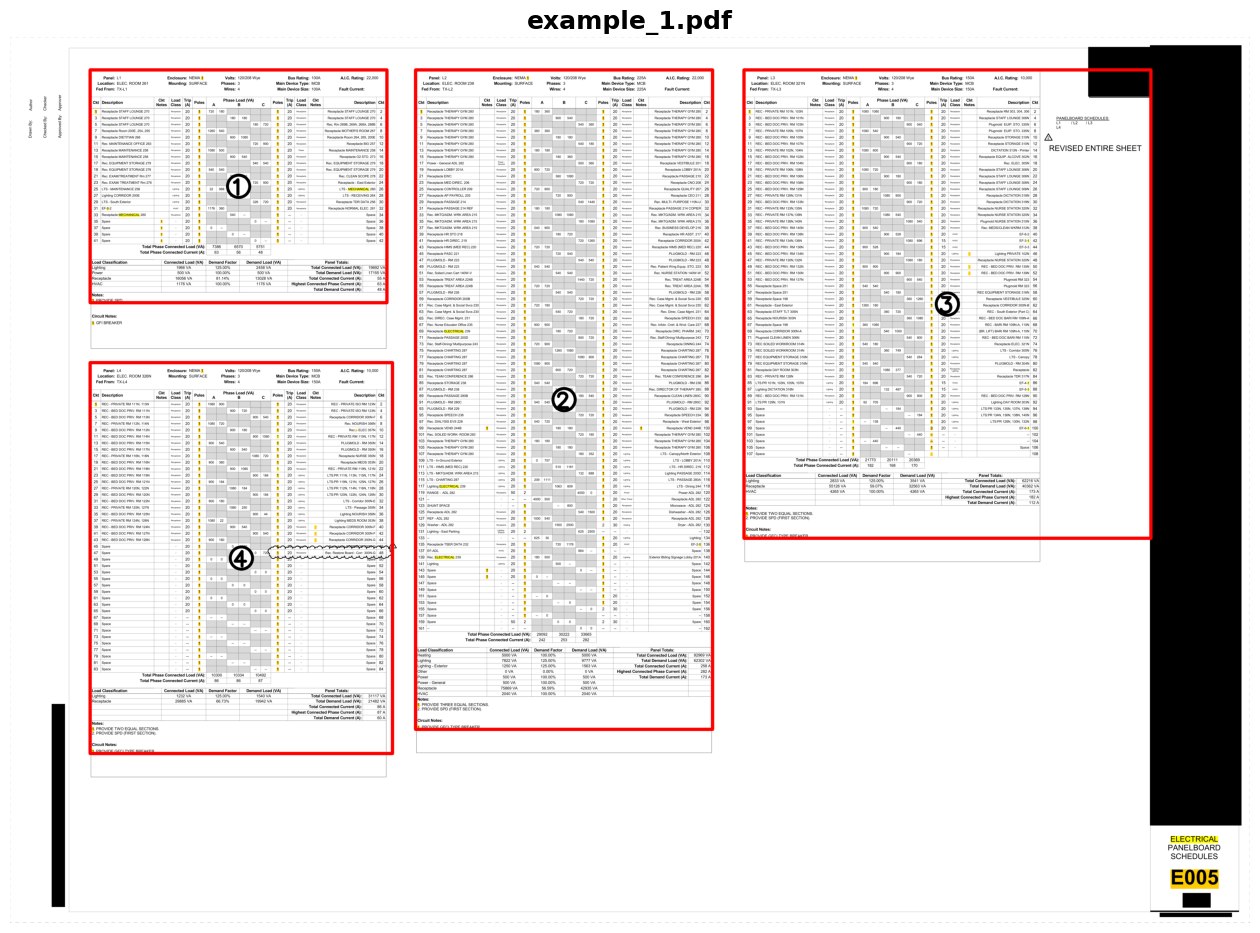

Amount of tables in PDF file: 4
Table title and position:
1. L1 | ELEC. ROOM 261 | TX-L1  (557.5, 364.0)
2. L2 | ELEC. ROOM 239 | TX-L2  (1351.3, 884.2)
3. L3 | ELEC. ROOM 321N | TX-L3 (2286.1, 651.2)
4. L4 | ELEC. ROOM 326N | TX-L4 (564.2, 1270.4)

JSON object:
{
  "pdf_file": "example_1.pdf",
  "amount_of_tables": 4,
  "table_title_position": [
    {
      "title": "L1 | ELEC. ROOM 261 | TX-L1",
      "x": 557.5,
      "y": 364.0
    },
    {
      "title": "L2 | ELEC. ROOM 239 | TX-L2",
      "x": 1351.3,
      "y": 884.2
    },
    {
      "title": "L3 | ELEC. ROOM 321N | TX-L3",
      "x": 2286.1,
      "y": 651.2
    },
    {
      "title": "L4 | ELEC. ROOM 326N | TX-L4",
      "x": 564.2,
      "y": 1270.4
    }
  ]
}


In [12]:
show_information_about_tables_in_file(directory_files_with_tables + "example_1.pdf")

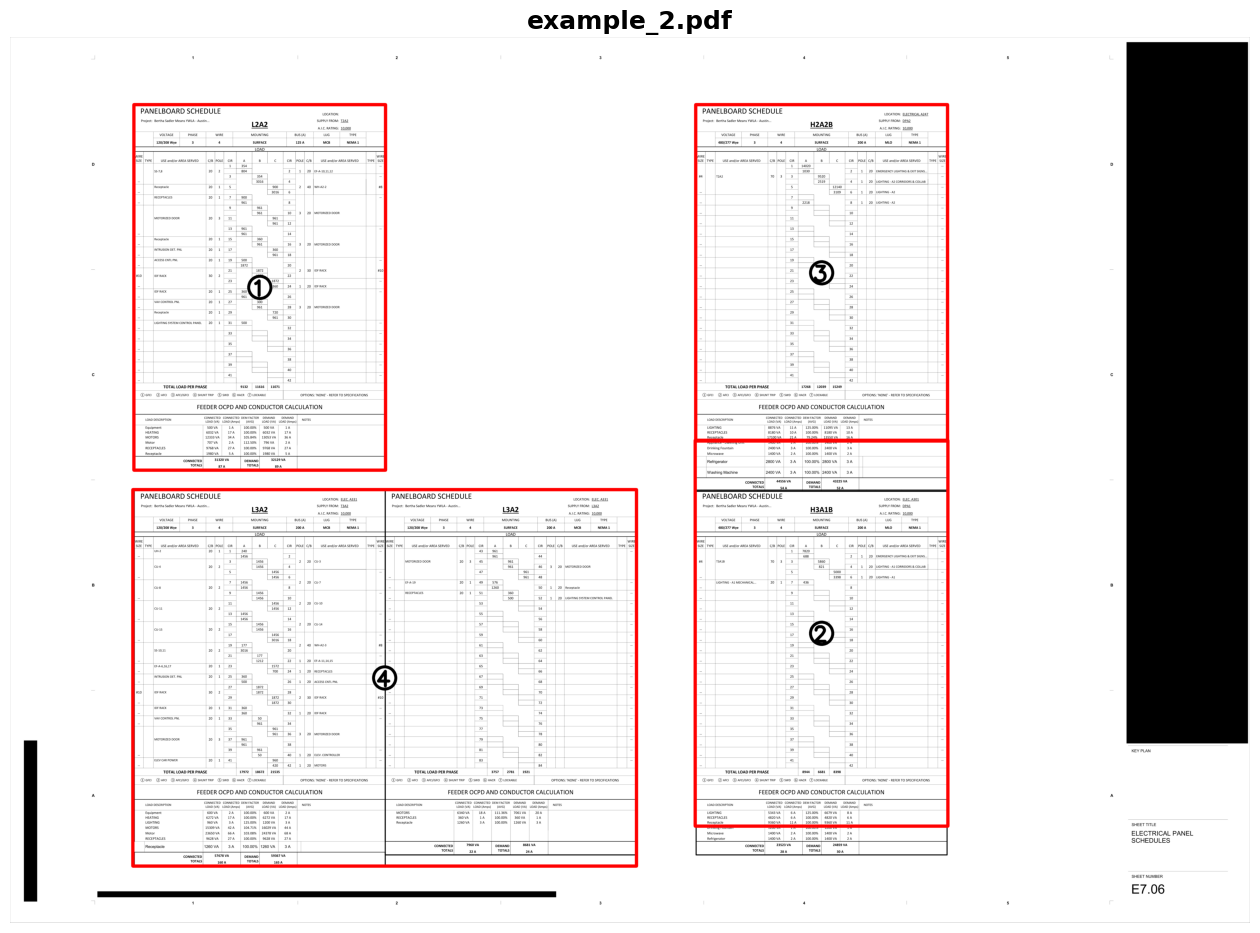

Amount of tables in PDF file: 4
Table title and position:
1. L2A2                     (609.1, 610.4)
2. H3A1B                    (1979.2, 1453.6)
3. H2A2B                    (1979.2, 574.8)
4. L3A2                     (913.8, 1562.4)

JSON object:
{
  "pdf_file": "example_2.pdf",
  "amount_of_tables": 4,
  "table_title_position": [
    {
      "title": "L2A2",
      "x": 609.1,
      "y": 610.4
    },
    {
      "title": "H3A1B",
      "x": 1979.2,
      "y": 1453.6
    },
    {
      "title": "H2A2B",
      "x": 1979.2,
      "y": 574.8
    },
    {
      "title": "L3A2",
      "x": 913.8,
      "y": 1562.4
    }
  ]
}


In [13]:
show_information_about_tables_in_file(directory_files_with_tables + "example_2.pdf")

  0%|          | 0/65814772 [00:00<?, ?it/s]

  0%|          | 0/63303144 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

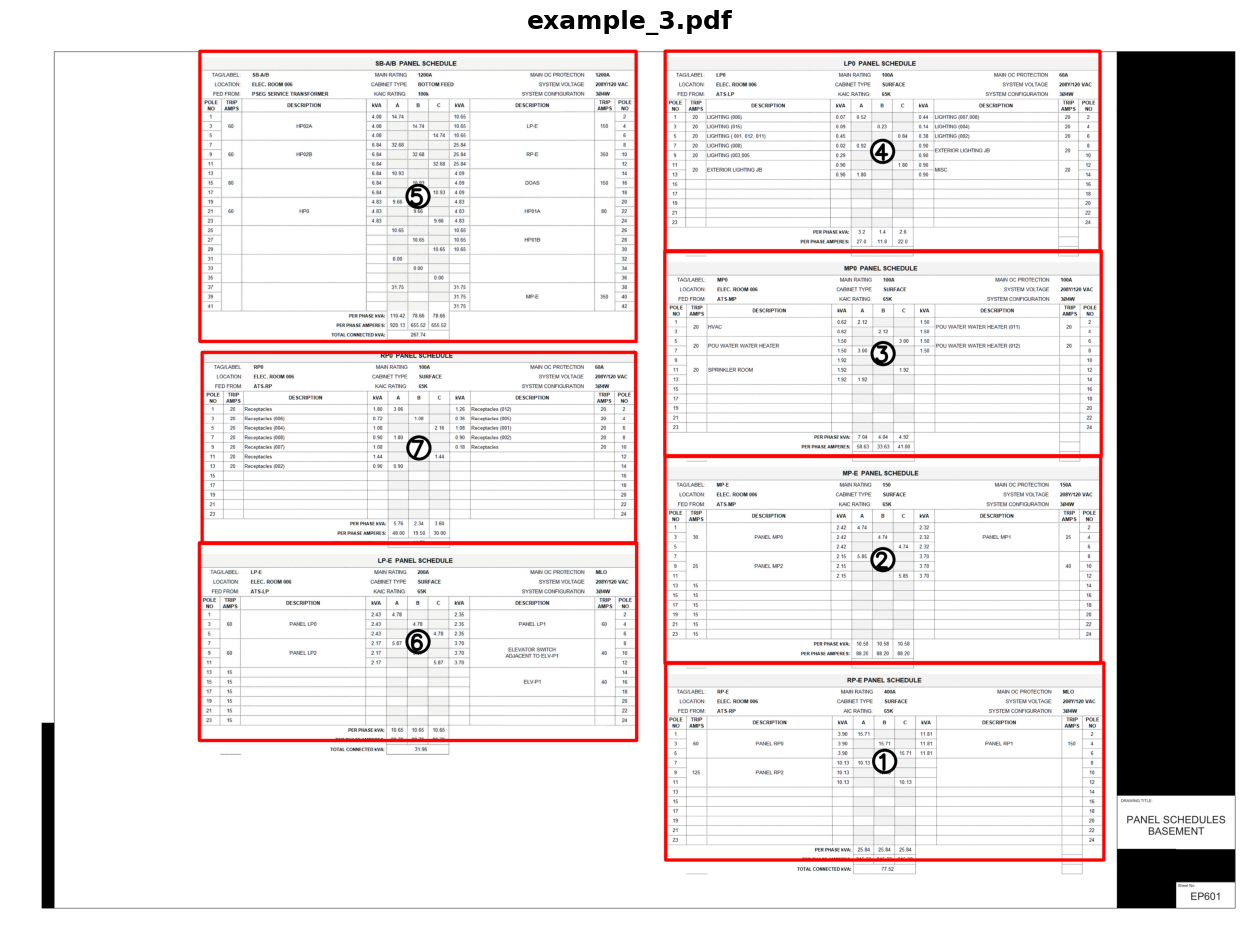

Amount of tables in PDF file: 7
Table title and position:
1. IMAL LC PL AW Jif RP-E P        (2133.3, 1765.9)
2. RATING 150A MAINOC PROTECTION   (2128.7, 1274.0)
3. Location / Fed From / Voltage   (2129.2, 772.0)
4. 8/6                             (2127.9, 278.8)
5. PANEL SCHEDULE TAG              (995.2, 388.4)
6. RATING 200A MAIN OC PROTECTION  (995.0, 1474.2)
7. RPO PANEL SCHEDULE TAG/LABEL: R (997.1, 1002.0)

JSON object:
{
  "pdf_file": "example_3.pdf",
  "amount_of_tables": 7,
  "table_title_position": [
    {
      "title": "IMAL LC PL AW Jif RP-E P",
      "x": 2133.3,
      "y": 1765.9
    },
    {
      "title": "RATING 150A MAINOC PROTECTION",
      "x": 2128.7,
      "y": 1274.0
    },
    {
      "title": "Location / Fed From / Voltage",
      "x": 2129.2,
      "y": 772.0
    },
    {
      "title": "8/6",
      "x": 2127.9,
      "y": 278.8
    },
    {
      "title": "PANEL SCHEDULE TAG",
      "x": 995.2,
      "y": 388.4
    },
    {
      "title": "RATING 200A MAIN O

In [14]:
show_information_about_tables_in_file(directory_files_with_tables + "example_3.pdf")

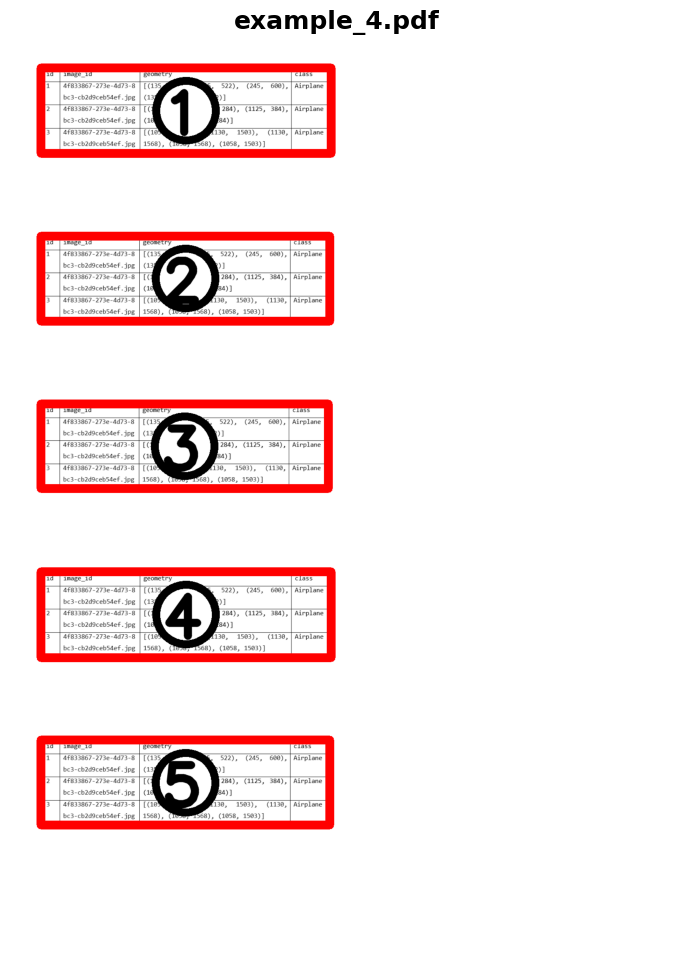

Amount of tables in PDF file: 5
Table title and position:
1. Airplane bc3-cb2d9ceb54  (160.4, 67.1)
2. Airplane bc3-cb2d9ceb54  (159.8, 220.1)
3. Airplane bc3-cb2d9ceb54  (159.1, 373.0)
4. Airplane bc3-cb2d9ceb54  (160.4, 526.4)
5. Airplane bc3-cb2d9ceb54  (159.8, 679.4)

JSON object:
{
  "pdf_file": "example_4.pdf",
  "amount_of_tables": 5,
  "table_title_position": [
    {
      "title": "Airplane bc3-cb2d9ceb54",
      "x": 160.4,
      "y": 67.1
    },
    {
      "title": "Airplane bc3-cb2d9ceb54",
      "x": 159.8,
      "y": 220.1
    },
    {
      "title": "Airplane bc3-cb2d9ceb54",
      "x": 159.1,
      "y": 373.0
    },
    {
      "title": "Airplane bc3-cb2d9ceb54",
      "x": 160.4,
      "y": 526.4
    },
    {
      "title": "Airplane bc3-cb2d9ceb54",
      "x": 159.8,
      "y": 679.4
    }
  ]
}


In [15]:
show_information_about_tables_in_file(directory_files_with_tables + "example_4.pdf")

In [16]:
show_information_about_tables_in_file(directory_files_with_tables + "example_5.pdf")

[PDF file 'example_5.pdf' contains 2 pages (only 1-page PDF files can be used)]


In [17]:
show_information_about_tables_in_file(directory_files_with_tables + "example_6.png")

[File 'example_6.png' is of a type other than PDF]
